In [85]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

In [86]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = 224

In [87]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_SIZE, IMG_SIZE))

Found 16000 files belonging to 8 classes.
Found 16000 files belonging to 8 classes.


In [88]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
# TODO HERE
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [89]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [90]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [91]:
base_model.trainable = False

# Adding a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [92]:
# Add a dense layer to convert it to a single prediction per image
# Test relu, leaky_relu, and sigmoid
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# We use binary accuracy here because of the Sigmoid?
# If we use a different activator then I am not sure 
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=10,
                    validation_data=validation_dataset,
                    validation_steps=10)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 208s 408ms/step - accuracy: 0.1263 - loss: -23.3054 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 402ms/step - accuracy: 0.1250 - loss: -36.8757 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 203s 407ms/step - accuracy: 0.1241 - loss: -38.7160 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 209s 418ms/step - accuracy: 0.1245 - loss: -39.5625 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 209s 419ms/step - accuracy: 0.1245 - loss: -39.5692 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 211s 422ms/step - accuracy: 0.1245 - loss: -39.7503 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 209s 419ms/step - accuracy: 0.1245 - loss: -39.7465 - val_accuracy: 0.1254 - val_loss: -39.7302
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 211s 423

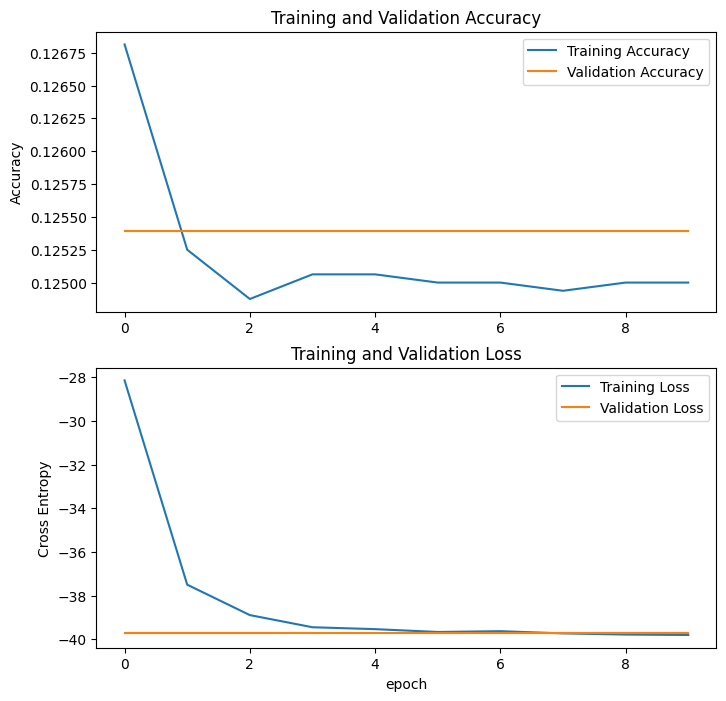

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         steps_per_epoch=10,
                         validation_data=validation_dataset,
                         validation_steps=10)

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)